In [168]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from scipy.stats import pearsonr, ttest_ind

response = requests.get('https://en.wikipedia.org/wiki/Doping_at_the_Olympic_Games')
FIRST_WINTER_INDEX = 17
NUMBER_OF_SUMMER_GAMES = 14
NUMBER_OF_WINTER_GAMES = 15

if response.status_code == 200:
    soup = BeautifulSoup(response.text)
    summer_country_dopes = {}
    winter_country_dopes = {}
    
    # These blocks sums up all mentions of each country in the "country" column of the doping scandal tables.
    # Added country names only include the part of the text in the column that is in a hyperlink
    # (e.g. "Russia (RUS)" gets added as "Russia")
    tables = soup.find_all('table', {'class': 'wikitable'})
    for table in tables[:17]:
        rows = table.find_all('tr')
        for row in rows:
            cells = row.find_all('td')
            if cells:
                country_cell = cells[1]
                country_hyperlink = country_cell.find('a')
                if country_hyperlink:
                    country_name = country_hyperlink.get_text(strip=True)
                    summer_country_dopes[country_name] = summer_country_dopes.get(country_name, 0) + 1

    # Same as above, but for winter instead of summer olympics
    for table in tables[17:]:
        rows = table.find_all('tr')
        for row in rows:
            cells = row.find_all('td')
            if cells:
                country_cell = cells[1]
                country_hyperlink = country_cell.find('a')
                if country_hyperlink:
                    country_name = country_hyperlink.get_text(strip=True)
                    winter_country_dopes[country_name] = winter_country_dopes.get(country_name, 0) + 1
else:
    print("Failed to retrieve the webpage.")

# Assemble scraped data into dataframe
pd.set_option('display.max_rows', None)
summer_dope_df = pd.DataFrame(list(summer_country_dopes.items()), columns=['Country', 'times_caught_doping'])
winter_dope_df = pd.DataFrame(list(winter_country_dopes.items()), columns=['Country', 'times_caught_doping'])

# Combine summer and winter dataframes into one dataframe
country_dope_counts = pd.merge(summer_dope_df, winter_dope_df, on='Country', how='outer')
country_dope_counts = country_dope_counts.fillna(0)
country_dope_counts['times_caught_doping'] = country_dope_counts['times_caught_doping_x'] + country_dope_counts['times_caught_doping_y']
country_dope_counts = country_dope_counts.drop(columns=['times_caught_doping_x', 'times_caught_doping_y'])

summer_dope_df['dopes_per_olympics'] = summer_dope_df['times_caught_doping'] / NUMBER_OF_SUMMER_GAMES
winter_dope_df['dopes_per_olympics'] = winter_dope_df['times_caught_doping'] / NUMBER_OF_WINTER_GAMES
country_dope_counts['dopes_per_olympics'] = country_dope_counts['times_caught_doping'] / (NUMBER_OF_SUMMER_GAMES + NUMBER_OF_WINTER_GAMES)


In [176]:
# Perform t-test
t_statistic, p_value = ttest_ind(summer_dope_df['dopes_per_olympics'], winter_dope_df['dopes_per_olympics'])
print(p_value)

0.7005531277238012


In [170]:
response_medals = requests.get('https://en.wikipedia.org/wiki/All-time_Olympic_Games_medal_table')

if response_medals.status_code == 200:
    medal_soup = BeautifulSoup(response_medals.text)
    country_medals = {}

    main_medal_table = medal_soup.find_all('table', {'class': 'wikitable'})[12]
    medal_rows = main_medal_table.find_all('tr')
    for medal_row in medal_rows:
        medal_cells = medal_row.find_all(['td', 'th'])
        if medal_cells:
            country_cell_for_medals = medal_cells[1]
            country_hyperlink = country_cell_for_medals.find('a')
            if country_hyperlink:
                country_name_for_medals = country_hyperlink.get_text(strip=True)
                country_medals[country_name_for_medals] = {
                    'Gold': int(medal_cells[2].text),
                    'Silver': int(medal_cells[3].text),
                    'Bronze': int(medal_cells[4].text),
                    'Total': int(medal_cells[5].text)
                }
else:
    print("Failed to retrieve the webpage.")

# Merge doping data with medal data
country_medals_df = pd.DataFrame(country_medals).T.reset_index()
country_medals_df.columns = ['Country', 'Gold', 'Silver', 'Bronze', 'Total']
all_data = pd.merge(country_dope_counts, country_medals_df, on='Country', how='outer')
all_data['medals_per_doper'] = all_data['Total'] / all_data['times_caught_doping']
all_data = all_data.sort_values(by='medals_per_doper', ascending=False).reset_index()
display(all_data)

# Medals v Dopes
# Unpunished Countries

# Summer vs winter t-test


,index,Country,times_caught_doping,dopes_per_olympics,Gold,Silver,Bronze,Total,medals_per_doper
0,106,Soviet Union,1.0,0.034483,473.0,376.0,355.0,1204.0,1204.000000
1,41,France,1.0,0.034483,264.0,293.0,332.0,889.0,889.000000
2,40,Finland,1.0,0.034483,146.0,150.0,184.0,480.0,480.000000
3,79,Netherlands,1.0,0.034483,148.0,154.0,167.0,469.0,469.000000
4,110,Switzerland,1.0,0.034483,116.0,126.0,132.0,374.0,374.000000
5,6,Australia,2.0,0.068966,170.0,180.0,216.0,566.0,283.000000
6,21,Canada,2.0,0.068966,148.0,182.0,221.0,551.0,275.500000
7,125,West Germany,1.0,0.034483,67.0,82.0,94.0,243.0,243.000000
8,59,Japan,3.0,0.103448,186.0,178.0,209.0,573.0,191.000000
9,83,Norway,3.0,0.103448,209.0,186.0,173.0,568.0,189.333333


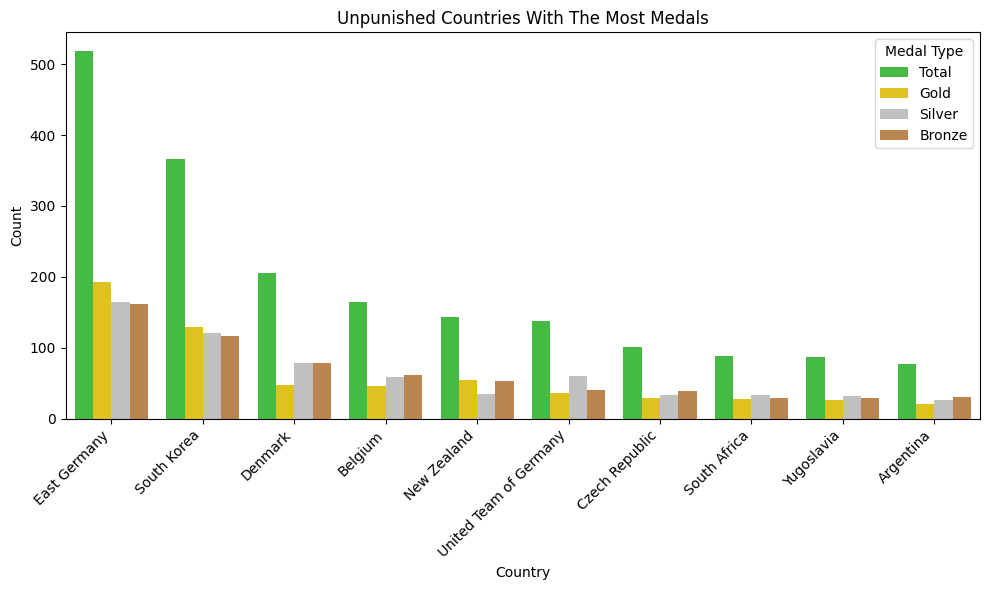

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt

zero_dope_countries = all_data[all_data['times_caught_doping'].isna()]
#display(zero_dope_countries)

# Bar graph will have separate columns for each medal type
top_countries = zero_dope_countries.nlargest(10, 'Total')
columns_to_keep = ['Country', 'Total', 'Gold', 'Silver', 'Bronze']
top_countries_medals = top_countries[columns_to_keep]
melted_df = top_countries_medals.melt(id_vars='Country', var_name='Medal', value_name='Count')

# Create the bar plot
plt.figure(figsize=(10, 6))
medal_colors = {'Gold': 'gold', 'Silver': 'silver', 'Bronze': 'peru', 'Total': 'limegreen'}
sns.barplot(x='Country', y='Count', hue='Medal', data=melted_df, palette=medal_colors)
plt.title('Unpunished Countries With The Most Medals')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.legend(title='Medal Type')
plt.show()


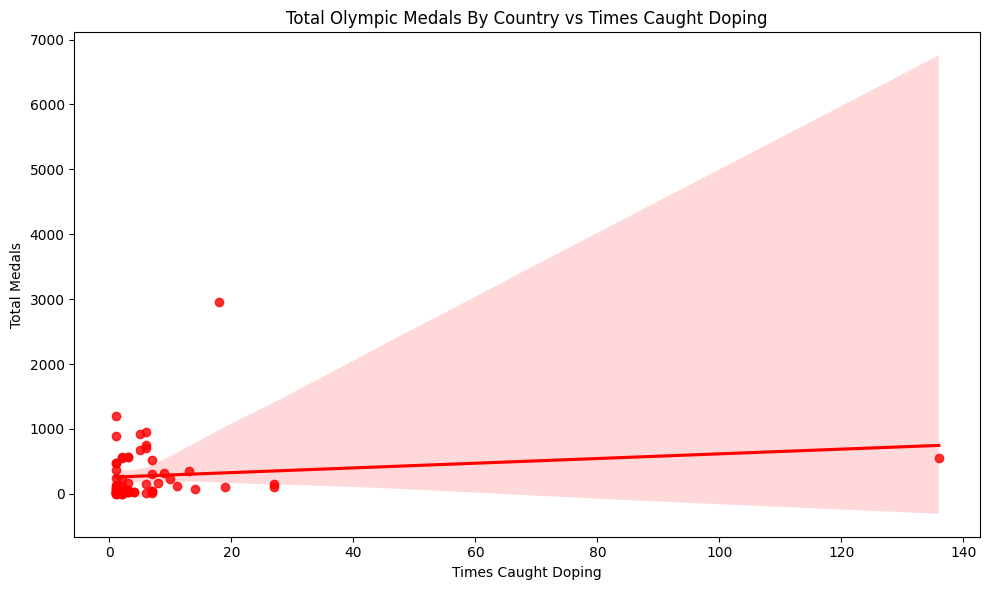

coefficient:  0.14061715819544304
p-value:  0.27166491006196547


In [172]:
# This gets rid of non-dopers and also gets rid of non-medalists
dope_countries = all_data.dropna()

# Make scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='times_caught_doping', y='Total', data=dope_countries, color="red")
plt.title('Total Olympic Medals By Country vs Times Caught Doping')
plt.xlabel('Times Caught Doping')
plt.ylabel('Total Medals')
plt.tight_layout()
plt.show()

corr_coeff, p_value = pearsonr(dope_countries['times_caught_doping'], dope_countries['Total'])
print("coefficient: ", corr_coeff)
print("p-value: ", p_value)

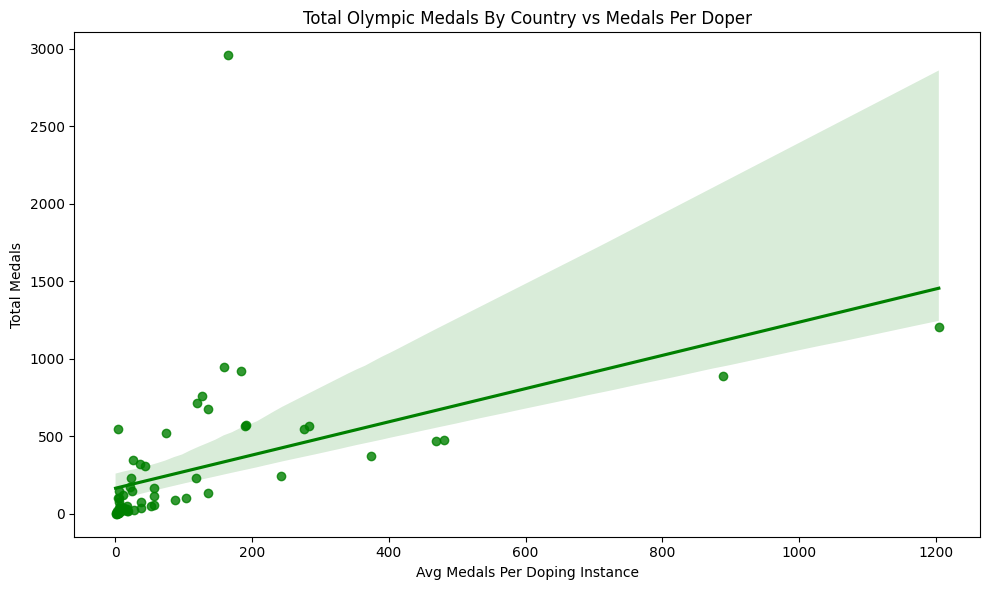

coefficient 0.49021413851494106
p-value: 4.538330449791338e-05


In [173]:
# Make scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='medals_per_doper', y='Total', data=dope_countries, color="green")
plt.title('Total Olympic Medals By Country vs Medals Per Doper')
plt.xlabel('Avg Medals Per Doping Instance')
plt.ylabel('Total Medals')
plt.tight_layout()
plt.show()

corr_coeff, p_value = pearsonr(dope_countries['medals_per_doper'], dope_countries['Total'])
print("coefficient", corr_coeff)
print("p-value:", p_value)